In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# 不要截断 DataFrames 的显示
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

tqdm.pandas()

In [2]:
"""
Note 1:
    我正在使用与我们的测试本身相似的验证集来验证我的结果。
    仅使用最近的数据进行训练，因为我将计算 2 年的滞后，我不希望有空值
"""
training_dates = ["2023-08-01", "2024-05-19"]
validation_dates = ["2024-05-20", "2024-06-02"]
test_dates = ["2024-06-03", "2024-06-16"]

In [3]:
lag_features = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 21, 28, 56, 56*2, 365, 365*2]

In [4]:
df_train = pd.read_csv("data/sales_train.csv")
df_test = pd.read_csv("data/sales_test.csv")
df_calendar = pd.read_csv("data/calendar.csv")
df_inventory = pd.read_csv("data/inventory.csv")
df_solution = pd.read_csv("data/solution.csv")
df_test_weights = pd.read_csv("data/test_weights.csv")

In [5]:
# 让我们看一下数据
# df_train.head()

In [6]:
"""
Note 2:
    我们希望最大限度地增加用于训练的类似用例的数量。
尽管每个 unique_id 的值范围不同，但我们可以缩放每个产品以使其具有相同的值。
这样，模型的泛化能力可能会更好。
"""

from sklearn.preprocessing import StandardScaler

scalers = {}
for unique_id in tqdm(df_train["unique_id"].unique()):
    scaler = StandardScaler()
    sales = df_train.loc[df_train["unique_id"] == unique_id, "sales"].values.reshape(-1, 1)
    scaler.fit(sales)
    scalers[unique_id] = scaler
    df_train.loc[df_train["unique_id"] == unique_id, "sales"] = scaler.transform(sales).flatten()

  0%|          | 0/5390 [00:00<?, ?it/s]

In [7]:
"""
Note 3:
    Fixing outliers didn't improve solution
"""

# Fix outliers for training data
# df_train.loc[df_train["date"].between(*training_dates), "sales"] = np.clip(df_train.loc[df_train["date"].between(*training_dates), "sales"], -5, 5)

"\nNote 3:\n    Fixing outliers didn't improve solution\n"

In [8]:
"""
Note 4:
    I tested using the same approach as before, to scale down total order for each warehouse
    But it didn't improve solution
"""

# # Standard scaler on the total_orders column for each warehouse
# scalers_total_orders = {}

# for warehouse in tqdm(df_train["warehouse"].unique()):
#     scaler = StandardScaler()
#     total_orders = df_train.loc[df_train["warehouse"] == warehouse, "total_orders"].values.reshape(-1, 1)
#     scaler.fit(total_orders)
#     scalers_total_orders[warehouse] = scaler
    
#     df_train.loc[df_train["warehouse"] == warehouse, "total_orders"] = scaler.transform(total_orders).flatten()

"\nNote 4:\n    I tested using the same approach as before, to scale down total order for each warehouse\n    But it didn't improve solution\n"

In [9]:
# Create an index for warehouse demand for each day
df = pd.concat([df_train, df_test], axis=0)

In [10]:
from datetime import datetime
czech_holiday = [ 
    (['03/31/2024', '04/09/2023', '04/17/2022', '04/04/2021', '04/12/2020'], 'Easter Day'),#loss
    (['05/12/2024', '05/10/2020', '05/09/2021', '05/08/2022', '05/14/2023'], "Mother Day"), #loss
]
brno_holiday = [
    (['03/31/2024', '04/09/2023', '04/17/2022', '04/04/2021', '04/12/2020'], 'Easter Day'),#loss
    (['05/12/2024', '05/10/2020', '05/09/2021', '05/08/2022', '05/14/2023'], "Mother Day"), #loss
]

budapest_holidays = []
munich_holidays = [
    (['03/30/2024', '04/08/2023', '04/16/2022', '04/03/2021'], 'Holy Saturday'),#loss
    (['05/12/2024', '05/14/2023', '05/08/2022', '05/09/2021'], 'Mother Day'),#loss
]

frank_holidays = [
    (['03/30/2024', '04/08/2023', '04/16/2022', '04/03/2021'], 'Holy Saturday'),#loss
    (['05/12/2024', '05/14/2023', '05/08/2022', '05/09/2021'], 'Mother Day'),#loss
]

def fill_loss_holidays(df_fill, warehouses, holidays):
    df = df_fill.copy()
    for item in holidays:
        dates, holiday_name = item
        generated_dates = [datetime.strptime(date, '%m/%d/%Y').strftime('%Y-%m-%d') for date in dates]
        for generated_date in generated_dates:
            df.loc[(df['warehouse'].isin(warehouses)) & (df['date'] == generated_date), 'holiday'] = 1
            df.loc[(df['warehouse'].isin(warehouses)) & (df['date'] == generated_date), 'holiday_name'] = holiday_name
    return df

df_calendar = fill_loss_holidays(df_fill=df_calendar, warehouses=['Prague_1', 'Prague_2', 'Prague_3'], holidays=czech_holiday)
df_calendar = fill_loss_holidays(df_fill=df_calendar, warehouses=['Brno_1'], holidays=brno_holiday)
df_calendar = fill_loss_holidays(df_fill=df_calendar, warehouses=['Munich_1'], holidays=munich_holidays)
df_calendar = fill_loss_holidays(df_fill=df_calendar, warehouses=['Frankfurt_1'], holidays=frank_holidays)
df_calendar = fill_loss_holidays(df_fill=df_calendar, warehouses=['Budapest_1'], holidays=budapest_holidays)

Frankfurt_1 = df_calendar.query('date >= "2020-08-01 00:00:00" and warehouse =="Frankfurt_1"')
Prague_2 = df_calendar.query('date >= "2020-08-01 00:00:00" and warehouse =="Prague_2"')
Brno_1 = df_calendar.query('date >= "2020-08-01 00:00:00" and warehouse =="Brno_1"')
Munich_1 = df_calendar.query('date >= "2020-08-01 00:00:00" and warehouse =="Munich_1"')
Prague_3 = df_calendar.query('date >= "2020-08-01 00:00:00" and warehouse =="Prague_3"')
Prague_1 = df_calendar.query('date >= "2020-08-01 00:00:00" and warehouse =="Prague_1"')
Budapest_1 = df_calendar.query('date >= "2020-08-01 00:00:00" and warehouse =="Budapest_1"')

def process_calendar(df):
    df = df.sort_values('date').reset_index(drop=True)
    df['datetime'] = pd.to_datetime(df['date'])
    df['next_holiday_date'] = df.loc[df['holiday'] == 1, 'datetime'].shift(-1)
    df['next_holiday_date'] = df['next_holiday_date'].bfill()
    df['days_to_holiday'] = (df['next_holiday_date'] - df['datetime']).dt.days
    df.drop(columns=['next_holiday_date'], inplace=True)
    df['next_shops_closed_date'] = df.loc[df['shops_closed'] == 1, 'datetime'].shift(-1)
    df['next_shops_closed_date'] = df['next_shops_closed_date'].bfill()
    df['days_to_shops_closed'] = (df['next_shops_closed_date'] - df['datetime']).dt.days
    df.drop(columns=['next_shops_closed_date'], inplace=True)
    df['day_after_closing'] = (
        (df['shops_closed'] == 0) & (df['shops_closed'].shift(1) == 1)
    ).astype(int)
    
    df['long_weekend'] = (
        (df['shops_closed'] == 1) & (df['shops_closed'].shift(1) == 1)
    ).astype(int)
    return df.drop(columns=['datetime'])

dfs = ['Frankfurt_1', 'Prague_2', 'Brno_1', 'Munich_1', 'Prague_3', 'Prague_1', 'Budapest_1']
processed_dfs = [process_calendar(globals()[df]) for df in dfs]
df_calendar_extended = pd.concat(processed_dfs).sort_values('date').reset_index(drop=True)

df = df.merge(df_calendar_extended, on=['date', 'warehouse'], how='left')

In [11]:
"""
Note 6:
    I tried to mine some extra info from total_orders
    If I understand correctly the total_orders for that day is mainly the order for the day
    But there were some cases where on some products the delivery is made on another days of something like that
    I was expecting that some value could be extracted from those cases
    For that reason I calculated: 
        total_order_median - the actual total orders for that day
        total_order_med_diff - difference between median and specific product
        warehouse_demand - calculated demand between 0 and 1 based on total_order_median (if 1 warehouse has the maximum demand to date)
"""

# Create a new column named total_orders_median
df["total_orders_median"] = df.groupby(["date", "warehouse"])["total_orders"].transform("median")
df["total_orders_med_diff"] = df["total_orders"] - df["total_orders_median"]

# Calculate all time max and min demand for each warehouse
df_warehouse_limits = df.groupby("warehouse")["total_orders"].agg(["max", "min"])

# warehouse demand should be between 0 and 1 based on the max and min demand of the warehouse
df["warehouse_demand"] = df.progress_apply(
    lambda x: (x["total_orders_median"] - df_warehouse_limits.loc[x["warehouse"], "min"]) / (
        df_warehouse_limits.loc[x["warehouse"], "max"] - df_warehouse_limits.loc[x["warehouse"], "min"]
    ),
    axis=1,
)

  0%|          | 0/4054440 [00:00<?, ?it/s]

In [12]:
"""
Note 7:
    Calculate average demand across all warehouses for each day
"""

# Create a new dataframe with 2 columns
# Dates and mean of total orders for each day
df_date = df.groupby("date")["total_orders"].mean().reset_index()
df_date = df_date.rename(columns={"total_orders": "daily_demand"})
df = df.merge(df_date, on="date", how="left")

In [13]:
df["max_discount"] = df[
    ["type_0_discount", "type_1_discount", "type_2_discount", "type_3_discount", "type_4_discount", "type_5_discount", "type_6_discount"]
].max(axis=1)

In [14]:
# Extract month, day, weekday, etc.
df["datetime"] = pd.to_datetime(df["date"])
df["month"] = df["datetime"].dt.month
df["day"] = df["datetime"].dt.day
df["weekday"] = df["datetime"].dt.weekday
df["quarter"] = df["datetime"].dt.quarter
df["week_of_year"] = df["datetime"].dt.isocalendar().week
df["day_of_year"] = df["datetime"].dt.dayofyear
df["is_weekend"] = df["datetime"].dt.weekday.isin([5, 6]).astype(int)
df["is_month_start"] = df["datetime"].dt.is_month_start.astype(int)
df["is_month_end"] = df["datetime"].dt.is_month_end.astype(int)
df['year_sin'] = np.sin(2 * np.pi * df['datetime'].dt.year)
df['year_cos'] = np.cos(2 * np.pi * df['datetime'].dt.year)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12) 
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)  
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)

df.drop(columns=["datetime"], inplace=True)

In [15]:
"""
Note 8:
    In the next cells I will calculate some lags
    I tried some approaches to fix missing values in between existing values for specific products
    But it didn't improve the solution
"""

# # Add columns with sales from previous periods
# df_all_dates = df[["unique_id", "date", "sales"]].copy()

# # Convert date to datetime
# df_all_dates["date"] = pd.to_datetime(df_all_dates["date"])

# # Create all dates for each unique_id
# all_dates = pd.date_range(df_all_dates["date"].min(), df_all_dates["date"].max(), freq="D")
# all_ids = df_all_dates["unique_id"].unique()

# # Create a complete DataFrame with all combinations of dates and unique_ids
# df_complete = pd.DataFrame(
#     [(date, id) for date in all_dates for id in all_ids],
#     columns=["date", "unique_id"]
# )

# # Merge the complete DataFrame with the original data
# df_all_dates = pd.merge(df_complete, df_all_dates, on=["date", "unique_id"], how="left")

# # Sort the DataFrame
# df_all_dates = df_all_dates.sort_values(["unique_id", "date"])

# # Perform forward fill and backward fill for each unique_id
# df_all_dates["sales"] = df_all_dates.groupby(["unique_id", "date"])["sales"].transform(lambda x: x.ffill().bfill())

# # Convert date back to string if needed
# df_all_dates["date"] = df_all_dates["date"].astype(str)
# df_all_dates

df_all_dates = df.sort_values("date").copy()

In [16]:
"""
Note 9:
    Calculate all the lags for sales in of the product in specific warehouse
    Note that the sales here are still scaled :)
"""

df_grouped = df_all_dates.groupby(["unique_id", "warehouse"])

for i in lag_features:
    df_all_dates[f"sales_item_warehouse_lag_{i}"] = df_grouped["sales"].shift(i)
    # shift but keep last value if there is no value
    df_all_dates[f"sales_item_warehouse_lag_{i}"] = df_all_dates[f"sales_item_warehouse_lag_{i}"].fillna(
        df_grouped["sales"].transform("last")
    )

# Merge the lag features back to the original dataframe
df = df.merge(
    df_all_dates[["date", "unique_id"] + [f"sales_item_warehouse_lag_{i}" for i in lag_features]],
    on=["date", "unique_id"],
    how="left"
)

In [17]:
"""
Note 10:
    Calculate all the lags for sales in of the product and product category for all warehouses combined
"""

df = df.merge(df_inventory, on=["unique_id", "warehouse"], how="left")

category_features = ["product_unique_id", "name", "L1_category_name_en", "L2_category_name_en", "L3_category_name_en", "L4_category_name_en"]

# Group by product_unique_id
for i in lag_features:
    df[f"sales_item_lag_{i}"] = df.groupby("product_unique_id")[f"sales_item_warehouse_lag_{i}"].transform("mean")
    df[f"sales_l1_lag_{i}"] = df.groupby("L1_category_name_en")[f"sales_item_warehouse_lag_{i}"].transform("mean") # 新增
    df[f"sales_l3_lag_{i}"] = df.groupby("L3_category_name_en")[f"sales_item_warehouse_lag_{i}"].transform("mean")
    df[f"sales_l4_lag_{i}"] = df.groupby("L4_category_name_en")[f"sales_item_warehouse_lag_{i}"].transform("mean")
    
df = df.drop(columns=category_features)

In [18]:
"""
Note 11:
    Tried to mine some inside info with weights as well
    Maybe the weights were calculated based on our sales target
"""
# Add weights
df = df.merge(df_test_weights, on="unique_id", how="left")

In [19]:
# Keep same order of rows, for the final prediction
df = df.sort_values(["date", "unique_id"])

In [20]:
# Feature encoding using Label Encoding
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for feature in ["warehouse", "holiday_name"]:
    le = LabelEncoder()
    df[feature] = le.fit_transform(df[feature])
    label_encoders[feature] = le

In [21]:
"""
Note 12:
    Not ideal for all solutions, but didn't explore this in depth yet
"""
df["sales"] = df["sales"].fillna(0)
df["warehouse_demand"] = df["warehouse_demand"].fillna(0)
df = df.fillna(0)

In [22]:
not_features = ["unique_id", "date", "sales", "availability"] 

In [23]:
# At the end we still need to reverse back to not scaled values
def inverse_norm(df_, indexes, y_pred):
    df_.loc[indexes, "prediction_norm"] = y_pred
    df_.loc[indexes, "y_pred"] = df_.groupby("unique_id")["prediction_norm"].transform(lambda x: scalers[x.name].inverse_transform(x.values.reshape(-1, 1)).flatten())
    y_pred = df_.loc[indexes, "y_pred"].values
    y_pred = np.where(y_pred < 0, 0, y_pred)
    df_ = df_.drop(columns=["prediction_norm", "y_pred"])
    return y_pred

In [24]:
"""
Note 13:
    This is the main train code
    The only aspect that I would like to share is the following idea:
    - We can use distinct range of lags based on the day of test
    For example for the day 0 of test set, we can use data until day -1 (lag=1)
    But for day 14, we still can use data until day -1 (lag=14)
    We can train a model for each day of training using more lags if possible.
"""
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error

def train_pipeline(df_, lag_features_, model_, training_dates_, validation_dates_, test_dates_, callbacks=[]):
    
    # "warehouse", 
    features = df_.columns.difference(not_features)
    target = "sales"

    # Drop rows with NaN values
    df_ = df_.dropna(subset=features)

    X_train = df_[df_["date"].between(*training_dates_)][features]
    y_train = df_[df_["date"].between(*training_dates_)][target]
    X_val = df_[df_["date"].between(*validation_dates_)][features]
    y_val = df_[df_["date"].between(*validation_dates_)][target]
    X_test = df_[df_["date"].between(*test_dates_)][features]
    y_test = df_[df_["date"].between(*test_dates_)][target]

    print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

    maew_list = []
    test_predictions = []
    val_predictions = []
    val_true = []
    
    print("validation_dates", validation_dates_)
    print("test_dates", test_dates_)
    print("Starting training")

    next_start = pd.to_datetime(validation_dates_[0])

    # Let's iterate over the lag features, and train a model_ for each
    for index, lag in enumerate(lag_features_):
        next_lag = lag_features_[index + 1] if index + 1 < len(lag_features_) else None
        
        print(f"Lag: {lag}, Next Lag: {next_lag}")

        # Get the validation and test days
        val_period_start = next_start
        val_period_end = next_start + pd.Timedelta(days=next_lag-lag)
        test_period_start = val_period_start + pd.Timedelta(days=14)
        test_period_end = val_period_end + pd.Timedelta(days=14)
        next_start = val_period_end
        
        if val_period_start > pd.to_datetime(validation_dates_[1]):
            print("No more validation days")
            break

        # Keep test outside val
        val_period_end = min(val_period_end, pd.to_datetime(test_dates[0]))
        
        val_period_start = str(val_period_start.date())
        val_period_end = str(val_period_end.date())
        test_period_start = str(test_period_start.date())
        test_period_end = str(test_period_end.date())

        # Do not use leakage features
        exclude = [l for l in lag_features_ if l < lag]
        leak_features = [c for c in X_train.columns if "lag" in c]
        leak_features = [c for c in leak_features if int(c.split("_")[-1]) in exclude]
        print(f"Removing features: {leak_features}")
        
        print(f"Validation period: {val_period_start} - {val_period_end}")
        print(f"Test period: {test_period_start} - {test_period_end}")

        # Filters
        val_period = df_["date"].between(val_period_start, val_period_end, inclusive="left")
        test_period = df_["date"].between(test_period_start, test_period_end, inclusive="left")
        
        # Prints days in periods
        print(f"Validation days: {df_[val_period]['date'].unique()}")
        print(f"Test days: {df_[test_period]['date'].unique()}")
        
        if len(df_[test_period]['date'].unique()) == 0:
            print("We got all the days for the test set")
            break

        # Filter data for the current day
        X_train_period = X_train.drop(columns=leak_features)
        y_train_period = y_train
        X_val_period = X_val.loc[val_period, :].drop(columns=leak_features)
        y_val_period = y_val[val_period]
        X_test_period = X_test.loc[test_period, :].drop(columns=leak_features)
        y_test_period = y_test[test_period]
        
        print(X_train_period.shape, y_train_period.shape, X_val_period.shape, y_val_period.shape, X_test_period.shape, y_test_period.shape)

        if model_.__class__.__name__ == "CatBoostRegressor":
            model_.fit(X_train_period, y_train_period, eval_set=(X_val_period, y_val_period))
        
        y_pred = inverse_norm(df_, val_period, model_.predict(X_val_period))
        val_predictions.append(y_pred) 
        y_val_period = inverse_norm(df_, val_period, y_val_period)
        val_true.append(y_val_period)

        # Calculate the error
        wmae = mean_absolute_error(y_val_period, y_pred, sample_weight=X_val_period["weight"])
        print(f"Lag {lag} got WMAE: {wmae}")
        for _ in range(df_[val_period]['date'].nunique()):
            maew_list.append(wmae)

        # Predict test set
        y_pred = model_.predict(X_test_period)
        y_pred = inverse_norm(df_, test_period, y_pred)

        # Save the prediction
        test_predictions.append(y_pred)

        try:
            # Feature Importances
            # Get feature importances
            feature_importances = model_.get_feature_importance()
            # Create a pandas Series for better visualization
            importance_df = pd.Series(feature_importances, index=X_train_period.columns).sort_values(ascending=False)
            # Print top 20 feature importances
            print("Top Feature Importances:")
            for feature, importance in importance_df.items():
                print(f"Feature: {feature}, Importance: {importance:.2f}")
        except:
            pass
            
        # Average Mean
        print(f"Average WMAE: {np.mean(maew_list)}")
        
    return maew_list, test_predictions, val_predictions, val_true

In [26]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error

model = CatBoostRegressor(
    iterations=10_000,
    #learning_rate=0.1,
    depth=10,
    loss_function="MAE",
    verbose=100,
    # random_seed=0,
    early_stopping_rounds=50,
    metric_period=100,  # 控制日志输出的频率
    task_type="GPU",  # 启用 GPU 加速
)
maew_list, test_predictions, val_predictions, val_true = train_pipeline(df, lag_features, model, training_dates, validation_dates, test_dates)

(1012483, 140) (1012483,) (47319, 140) (47319,) (47021, 140) (47021,)
validation_dates ['2024-05-20', '2024-06-02']
test_dates ['2024-06-03', '2024-06-16']
Starting training
Lag: 1, Next Lag: 2
Removing features: []
Validation period: 2024-05-20 - 2024-05-21
Test period: 2024-06-03 - 2024-06-04
Validation days: ['2024-05-20']
Test days: ['2024-06-03']
(1012483, 140) (1012483,) (3231, 140) (3231,) (3386, 140) (3386,)
0:	learn: 0.7181766	test: 0.7076759	best: 0.7076759 (0)	total: 483ms	remaining: 1h 20m 26s
100:	learn: 0.5054031	test: 0.5346291	best: 0.5346291 (100)	total: 4.69s	remaining: 7m 39s
200:	learn: 0.4673778	test: 0.5075396	best: 0.5075396 (200)	total: 8s	remaining: 6m 30s
300:	learn: 0.4532395	test: 0.4925942	best: 0.4925942 (300)	total: 11.2s	remaining: 5m 59s
400:	learn: 0.4456788	test: 0.4854451	best: 0.4854451 (400)	total: 14.4s	remaining: 5m 45s
500:	learn: 0.4403960	test: 0.4813004	best: 0.4813004 (500)	total: 17.8s	remaining: 5m 36s
600:	learn: 0.4364264	test: 0.4777794

C:\Users\jiayezi\AppData\Local\Temp\ipykernel_16052\4156201366.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val["prediction"] = np.concatenate(val_predictions)
C:\Users\jiayezi\AppData\Local\Temp\ipykernel_16052\4156201366.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val["true"] = np.concatenate(val_true)
C:\Users\jiayezi\AppData\Local\Temp\ipykernel_16052\4156201366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

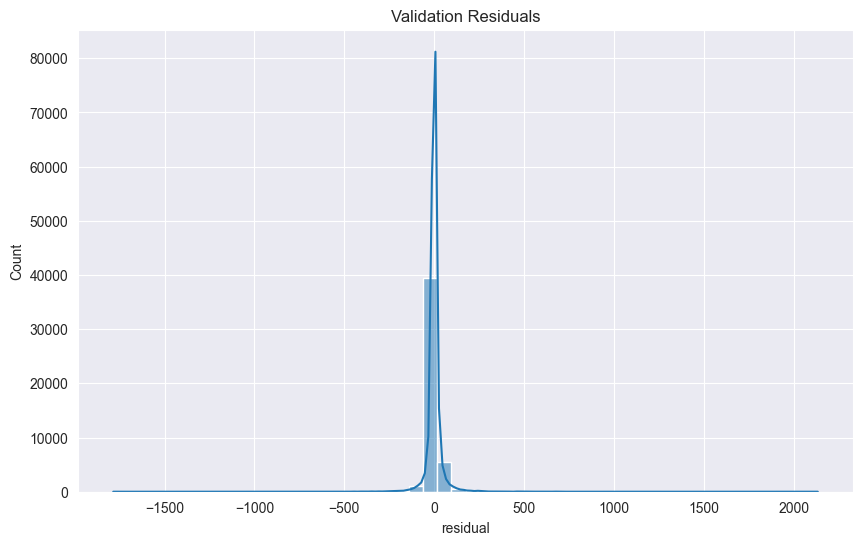

In [27]:
# Analyze Validation Residuals
# Filter df_val 
df_val = df[df["date"].between(*validation_dates)]
df_val["prediction"] = np.concatenate(val_predictions)
df_val["true"] = np.concatenate(val_true)
df_val["residual"] = df_val["true"] - df_val["prediction"]

# Plot residuals
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(df_val["residual"], bins=50, kde=True)
plt.title("Validation Residuals")
plt.show()

In [28]:
# Top 10 greater residuals
df_val.sort_values("residual", ascending=False).head(10)

,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,days_to_holiday,days_to_shops_closed,day_after_closing,long_weekend,total_orders_median,total_orders_med_diff,warehouse_demand,daily_demand,max_discount,month,day,weekday,quarter,week_of_year,day_of_year,is_weekend,is_month_start,is_month_end,year_sin,year_cos,month_sin,month_cos,day_sin,day_cos,sales_item_warehouse_lag_1,sales_item_warehouse_lag_2,sales_item_warehouse_lag_3,sales_item_warehouse_lag_4,sales_item_warehouse_lag_5,sales_item_warehouse_lag_6,sales_item_warehouse_lag_7,sales_item_warehouse_lag_8,sales_item_warehouse_lag_9,sales_item_warehouse_lag_10,sales_item_warehouse_lag_11,sales_item_warehouse_lag_12,sales_item_warehouse_lag_13,sales_item_warehouse_lag_14,sales_item_warehouse_lag_21,sales_item_warehouse_lag_28,sales_item_warehouse_lag_56,sales_item_warehouse_lag_112,sales_item_warehouse_lag_365,sales_item_warehouse_lag_730,sales_item_lag_1,sales_l1_lag_1,sales_l3_lag_1,sales_l4_lag_1,sales_item_lag_2,sales_l1_lag_2,sales_l3_lag_2,sales_l4_lag_2,sales_item_lag_3,sales_l1_lag_3,sales_l3_lag_3,sales_l4_lag_3,sales_item_lag_4,sales_l1_lag_4,sales_l3_lag_4,sales_l4_lag_4,sales_item_lag_5,sales_l1_lag_5,sales_l3_lag_5,sales_l4_lag_5,sales_item_lag_6,sales_l1_lag_6,sales_l3_lag_6,sales_l4_lag_6,sales_item_lag_7,sales_l1_lag_7,sales_l3_lag_7,sales_l4_lag_7,sales_item_lag_8,sales_l1_lag_8,sales_l3_lag_8,sales_l4_lag_8,sales_item_lag_9,sales_l1_lag_9,sales_l3_lag_9,sales_l4_lag_9,sales_item_lag_10,sales_l1_lag_10,sales_l3_lag_10,sales_l4_lag_10,sales_item_lag_11,sales_l1_lag_11,sales_l3_lag_11,sales_l4_lag_11,sales_item_lag_12,sales_l1_lag_12,sales_l3_lag_12,sales_l4_lag_12,sales_item_lag_13,sales_l1_lag_13,sales_l3_lag_13,sales_l4_lag_13,sales_item_lag_14,sales_l1_lag_14,sales_l3_lag_14,sales_l4_lag_14,sales_item_lag_21,sales_l1_lag_21,sales_l3_lag_21,sales_l4_lag_21,sales_item_lag_28,sales_l1_lag_28,sales_l3_lag_28,sales_l4_lag_28,sales_item_lag_56,sales_l1_lag_56,sales_l3_lag_56,sales_l4_lag_56,sales_item_lag_112,sales_l1_lag_112,sales_l3_lag_112,sales_l4_lag_112,sales_item_lag_365,sales_l1_lag_365,sales_l3_lag_365,sales_l4_lag_365,sales_item_lag_730,sales_l1_lag_730,sales_l3_lag_730,sales_l4_lag_730,weight,prediction,true,residual
4006667,2754,2024-06-02,3,2962.0,4.666825,0.69,1.00,0.13502,0.0,0.00000,0.0,0.0,0.0,0.0,39,0.0,0.0,0.0,1.0,74.0,123.0,0.0,0.0,2962.0,0.0,0.347392,6345.083283,0.13502,6,2,6,2,22,154,1,0,0,1.585375e-14,1.0,1.224647e-16,-1.000000,0.394356,0.918958,2.253251,3.217266,0.197224,0.034495,0.100203,0.517933,-0.130976,0.106819,0.529636,-0.029524,-0.393528,1.436944,-0.300957,0.141511,-0.301056,-0.524704,4.666825,4.666825,4.666825,4.666825,0.597600,0.001603,0.015602,0.001727,0.597600,0.001551,0.014709,0.001669,0.597600,0.001518,0.013427,0.001626,0.597600,0.001475,0.012087,0.001573,0.597600,0.001423,0.011110,0.001504,0.597600,0.001360,0.009572,0.001419,0.597600,0.001296,0.008733,0.001332,0.597600,0.001234,0.006715,0.001231,0.597600,0.001182,0.004828,0.001139,0.597600,0.001152,0.004044,0.001090,0.597600,0.001112,0.003161,0.001027,0.623006,0.001095,0.002573,0.000980,0.638264,0.001044,0.002229,0.000904,0.670196,0.000995,0.001636,0.000840,0.997894,0.000403,0.002579,-0.000026,1.415846,-0.000386,0.007039,-0.001247,3.081998,-0.003779,0.041080,-0.005521,3.136886,-0.007591,0.107628,-0.009758,3.136886,0.038630,0.328903,0.042703,3.136886,0.103268,0.432173,0.118604,1.215812,531.741095,2665.04,2133.298905
1626498,620,2024-05-22,0,8912.0,5.528404,109.66,0.44,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,39,0.0,0.0,0.0,0.0,45.0,159.0,0.0,0.0,8912.0,0.0,0.545413,6822.300532,0.00000,5,22,2,2,21,143,0,0,0,1.585375e-14,1.0,5.000000e-01,-0.866025,-0.968077,-0.250653,-0.433613,-0.388714,4.329259,3.900420,6.829837,2.066474,5.419178,5.539795,5.316804,-0.573311,-0.493256,-0.293307,-0

In [29]:
# Top 10 smaller residuals
df_val.sort_values("residual", ascending=True).head(10)

,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,days_to_holiday,days_to_shops_closed,day_after_closing,long_weekend,total_orders_median,total_orders_med_diff,warehouse_demand,daily_demand,max_discount,month,day,weekday,quarter,week_of_year,day_of_year,is_weekend,is_month_start,is_month_end,year_sin,year_cos,month_sin,month_cos,day_sin,day_cos,sales_item_warehouse_lag_1,sales_item_warehouse_lag_2,sales_item_warehouse_lag_3,sales_item_warehouse_lag_4,sales_item_warehouse_lag_5,sales_item_warehouse_lag_6,sales_item_warehouse_lag_7,sales_item_warehouse_lag_8,sales_item_warehouse_lag_9,sales_item_warehouse_lag_10,sales_item_warehouse_lag_11,sales_item_warehouse_lag_12,sales_item_warehouse_lag_13,sales_item_warehouse_lag_14,sales_item_warehouse_lag_21,sales_item_warehouse_lag_28,sales_item_warehouse_lag_56,sales_item_warehouse_lag_112,sales_item_warehouse_lag_365,sales_item_warehouse_lag_730,sales_item_lag_1,sales_l1_lag_1,sales_l3_lag_1,sales_l4_lag_1,sales_item_lag_2,sales_l1_lag_2,sales_l3_lag_2,sales_l4_lag_2,sales_item_lag_3,sales_l1_lag_3,sales_l3_lag_3,sales_l4_lag_3,sales_item_lag_4,sales_l1_lag_4,sales_l3_lag_4,sales_l4_lag_4,sales_item_lag_5,sales_l1_lag_5,sales_l3_lag_5,sales_l4_lag_5,sales_item_lag_6,sales_l1_lag_6,sales_l3_lag_6,sales_l4_lag_6,sales_item_lag_7,sales_l1_lag_7,sales_l3_lag_7,sales_l4_lag_7,sales_item_lag_8,sales_l1_lag_8,sales_l3_lag_8,sales_l4_lag_8,sales_item_lag_9,sales_l1_lag_9,sales_l3_lag_9,sales_l4_lag_9,sales_item_lag_10,sales_l1_lag_10,sales_l3_lag_10,sales_l4_lag_10,sales_item_lag_11,sales_l1_lag_11,sales_l3_lag_11,sales_l4_lag_11,sales_item_lag_12,sales_l1_lag_12,sales_l3_lag_12,sales_l4_lag_12,sales_item_lag_13,sales_l1_lag_13,sales_l3_lag_13,sales_l4_lag_13,sales_item_lag_14,sales_l1_lag_14,sales_l3_lag_14,sales_l4_lag_14,sales_item_lag_21,sales_l1_lag_21,sales_l3_lag_21,sales_l4_lag_21,sales_item_lag_28,sales_l1_lag_28,sales_l3_lag_28,sales_l4_lag_28,sales_item_lag_56,sales_l1_lag_56,sales_l3_lag_56,sales_l4_lag_56,sales_item_lag_112,sales_l1_lag_112,sales_l3_lag_112,sales_l4_lag_112,sales_item_lag_365,sales_l1_lag_365,sales_l3_lag_365,sales_l4_lag_365,sales_item_lag_730,sales_l1_lag_730,sales_l3_lag_730,sales_l4_lag_730,weight,prediction,true,residual
666899,4720,2024-05-22,0,8433.0,0.244652,2.30,1.00,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,39,0.0,0.0,0.0,0.0,45.0,159.0,0.0,0.0,8912.0,-479.0,0.545413,6822.300532,0.00000,5,22,2,2,21,143,0,0,0,1.585375e-14,1.0,5.000000e-01,-0.866025,-9.680771e-01,-0.250653,0.559528,0.247787,1.069412,1.539526,2.749974,0.939316,0.433527,0.792555,0.684388,0.825609,1.234146,2.168325,1.068945,3.945676,1.204940,0.495400,1.716744,0.908590,0.390339,0.055311,0.011336,0.000422,0.000593,-0.000073,0.011336,0.000385,0.000528,-0.000111,0.011336,0.000366,0.000477,-0.000142,0.011336,0.000365,0.000429,-0.000156,0.011336,0.000372,0.000393,-0.000170,0.011336,0.000361,0.000394,-0.000201,0.011336,0.000356,0.000336,-0.000230,0.011336,0.000344,0.000270,-0.000264,0.011336,0.000356,0.000220,-0.000270,0.011336,0.000386,0.000195,-0.000262,0.011336,0.000413,0.000139,-0.000247,0.011336,0.000429,0.000049,-0.000252,0.011336,0.000450,0.000021,-0.000247,0.011336,0.000476,-0.000047,-0.000226,0.011849,-0.000795,-0.001028,-0.001855,0.012317,-0.002125,-0.002323,-0.003518,0.007644,-0.007711,-0.009887,-0.010279,0.004872,-0.013543,-0.026341,-0.018826,0.169591,-0.002014,-0.020383,-0.014222,0.413278,0.051266,0.095021,0.031775,0.174985,14782.163245,12996.74,-1785.423245
666965,4720,2024-05-20,0,8426.0,0.247787,2.30,1.00,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,39,0.0,0.0,0.0,0.0,47.0,161.0,0.0,0.0,8829.0,-403.0,0.537798,6534.204271,0.00000,5,20,0,2,21,141,0,0,0,1.585375e-14,1.0,5.000000e-01,-0.866025,-7.907757e-01,-0.612106,1.069412,1.539526,2.749974,0.939316,0.433527,0.792555,0.684388,0.825609,1.234146

In [30]:
# Group for each unique_id
df_res_unique_id = df_val.groupby("unique_id")["residual"].mean().reset_index()
df_res_unique_id = df_res_unique_id.rename(columns={"residual": "residual_unique"})
df_res_unique_id.sort_values("residual_unique", ascending=False, inplace=True)
df_res_unique_id.head()

,unique_id,residual_unique
410,653,563.047435
409,652,455.459831
1816,2754,366.742581
412,655,366.448554
245,394,348.623494


In [31]:
# Group for warehouse
df_res_warehouse = df_val.groupby("warehouse")["residual"].mean().reset_index()
df_res_warehouse = df_res_warehouse.rename(columns={"residual": "residual_warehouse"})
df_res_warehouse.sort_values("residual_warehouse", ascending=False, inplace=True)
df_res_warehouse.head()

,warehouse,residual_warehouse
3,3,10.646884
5,5,2.008520
2,2,0.638129
0,0,0.389034
6,6,-0.336334


In [32]:
# Group for day
df_res_date = df_val.groupby("date")["residual"].mean().reset_index()
df_res_date = df_res_date.rename(columns={"residual": "residual_date"})
df_res_date.sort_values("residual_date", ascending=False, inplace=True)
df_res_date.head()

,date,residual_date
7,2024-05-27,2.773802
0,2024-05-20,2.669728
4,2024-05-24,2.405059
13,2024-06-02,1.869214
2,2024-05-22,1.318764


In [33]:
import math
maew_mean = np.mean(maew_list)
maew_mean = math.floor(maew_mean * 100_000) / 100_000
print(f"Mean WMAE: {maew_mean}")

Mean WMAE: 17.62582


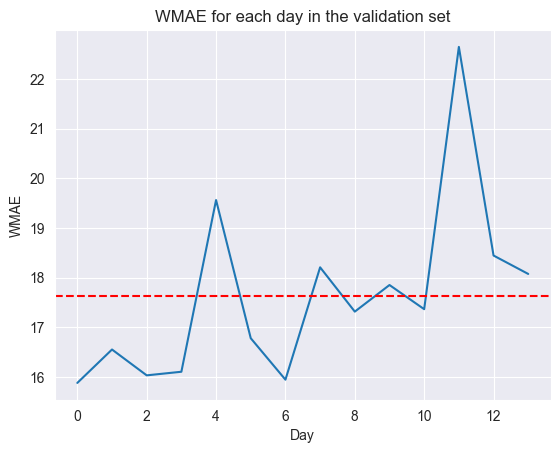

In [34]:
# Plot the errors, add a line for the mean
import matplotlib.pyplot as plt

plt.plot(maew_list)
plt.axhline(np.mean(maew_list), color="red", linestyle="--")
plt.xlabel("Day")
plt.ylabel("WMAE")
plt.title("WMAE for each day in the validation set")
plt.show()

In [35]:
df_test = pd.read_csv("data/sales_test.csv")
df_test = df_test.sort_values(["date", "unique_id"])
df_test["sales_hat"] = np.array([item for sublist in test_predictions for item in sublist]) # model.predict(X_test)
df_test.head()

,unique_id,date,warehouse,total_orders,sell_price_main,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount,sales_hat
40599,1,2024-06-03,Frankfurt_1,1725.0,2.87,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,175.759439
24047,2,2024-06-03,Munich_1,5254.0,3.34,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,255.230788
45927,3,2024-06-03,Budapest_1,6598.0,702.89,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,88.814767
38174,7,2024-06-03,Munich_1,5254.0,1.14,0.0,0.0,0.0,0.0,0.15385,0.0,0.00000,31.192049
37237,9,2024-06-03,Prague_1,10256.0,48.97,0.0,0.0,0.0,0.0,0.15000,0.0,0.05616,30.275020


In [36]:
"""
Note 14:
    Our residuals in test set should be similar to the validation set, as the weeks are very close to each other
    If we are predicting to low sales for a specific warehouse we can adjust our test prediction for better based
    on the average residuals of each warehouse for the validation set.
    I do the same for warehouses and for each product
    The idea here is very similar to the one someone mentioned allready which consisted of multiplying our prediction with 1.02
"""

# Adjust sales_hat based on residuals
df_test = df_test.merge(df_res_unique_id, on="unique_id", how="left")
df_test["warehouse"] = label_encoders["warehouse"].transform(df_test["warehouse"])
df_test = df_test.merge(df_res_warehouse, on="warehouse", how="left")

df_test["residual_unique"] = df_test["residual_unique"].fillna(0)
df_test["residual_warehouse"] = df_test["residual_warehouse"].fillna(0)

df_test["sales_hat"] = df_test["sales_hat"] + 0.1*df_test["residual_unique"] + 0.1*df_test["residual_warehouse"]

In [37]:
# save submission file with predictions
df_test["id"] = df_test["unique_id"].astype(str) + "_" + pd.to_datetime(df_test["date"]).dt.strftime("%Y-%m-%d")
df_test[["id", "sales_hat"]].to_csv(f"submission.csv", index=False)